# Stock Selection using Machine Learning Techniques
by Chee-Foong（曾志峰）from Singapore（新加坡）on 8 Jul 2020

## Summary
Purpose of this analysis is to predict 1-month stock returns of securities in CSI 300.  Based on predicted returns performance, each stock will be assigned to different performance categories.  Stocks with good performance will be picked and invested at the end of the month.  

This process will repeat every month and the strategy will be backtested to determine with whether the prediction model is good enough for consistent outperformance over the index/benchmark.

I welcome any comments/feedbacks on this analysis.  If you spot any mistakes, please let me know.


### References
Thank you to the authors of the following references for their work and sharing what they have done.
1. [A Sustainable Quantitative Stock Selection Strategy Based on Dynamic Factor Adjustment](https://www.researchgate.net/publication/341376900_A_Sustainable_Quantitative_Stock_Selection_Strategy_Based_on_Dynamic_Factor_Adjustment)
2. [Stock selection strategy of A-share market based on rotation effect and random forest](https://www.researchgate.net/publication/341596634_Stock_selection_strategy_of_A-share_market_based_on_rotation_effect_and_random_forest)

---
## Loading the libraries

In [34]:
import time

import numpy as np
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

Preparing list of factors of interest

In [2]:
factors = {'net_profit_to_total_operate_revenue_ttm': 'Quality',
 'DEGM': 'Quality',
 'roe_ttm': 'Quality',
 'GMI': 'Quality',
 'ACCA': 'Quality',
 'financial_liability': 'Fundamental',
 'cash_flow_to_price_ratio': 'Fundamental',
 'market_cap': 'Fundamental',
 'net_profit_ttm': 'Fundamental',
 'EBIT': 'Fundamental',
 'VOL20': 'Emotional',
 'DAVOL20': 'Emotional',
 'VOSC': 'Emotional',
 'VMACD': 'Emotional',
 'ATR14': 'Emotional',
 'PEG': 'Growth',
 'net_profit_growth_rate': 'Growth',
 'operating_revenue_growth_rate': 'Growth',
 'net_asset_growth_rate': 'Growth',
 'net_operate_cashflow_growth_rate': 'Growth',
 'Variance20': 'Risk',
 'sharpe_ratio_20': 'Risk',
 'Kurtosis20': 'Risk',
 'Skewness20': 'Risk',
 'sharpe_ratio_60': 'Risk',
 'net_asset_per_share': 'Stock',
 'net_operate_cash_flow_per_share': 'Stock',
 'eps_ttm': 'Stock',
 'retained_earnings_per_share': 'Stock',
 'cashflow_per_share_ttm': 'Stock',
 'ROC20': 'Momentum',
 'Volume1M': 'Momentum',
 'TRIX10': 'Momentum',
 'Price1M': 'Momentum',
 'PLRC12': 'Momentum',
 'MAC20': 'Technical',
 'boll_down': 'Technical',
 'boll_up': 'Technical',
 'MFI14': 'Technical',
 'size': 'Style',
 'beta': 'Style',
 'momentum': 'Style',
 'book_to_price_ratio': 'Style',
 'liquidity': 'Style',
 'growth': 'Style'}

In [3]:
factor_list = []
for key in factors:
    factor_list.append(key)

In [4]:
print(factor_list)

['net_profit_to_total_operate_revenue_ttm', 'DEGM', 'roe_ttm', 'GMI', 'ACCA', 'financial_liability', 'cash_flow_to_price_ratio', 'market_cap', 'net_profit_ttm', 'EBIT', 'VOL20', 'DAVOL20', 'VOSC', 'VMACD', 'ATR14', 'PEG', 'net_profit_growth_rate', 'operating_revenue_growth_rate', 'net_asset_growth_rate', 'net_operate_cashflow_growth_rate', 'Variance20', 'sharpe_ratio_20', 'Kurtosis20', 'Skewness20', 'sharpe_ratio_60', 'net_asset_per_share', 'net_operate_cash_flow_per_share', 'eps_ttm', 'retained_earnings_per_share', 'cashflow_per_share_ttm', 'ROC20', 'Volume1M', 'TRIX10', 'Price1M', 'PLRC12', 'MAC20', 'boll_down', 'boll_up', 'MFI14', 'size', 'beta', 'momentum', 'book_to_price_ratio', 'liquidity', 'growth']


In [5]:
print('Total number of factors: {}'.format(len(factor_list)))

Total number of factors: 45


## Extracting Data from JQData

### Factor data

Requests are sent on a batch basis due to limit to the amount of data to extract per request.  One factor per year per request.

In [6]:
# 导入函数库
from jqfactor import get_factor_values

# benchmark_index = '000001.XSHG' ## 上证指数
benchmark_index = '000300.XSHG' ## 沪深300

stocks = get_index_stocks(benchmark_index) 

# factor_list = ['liquidity','Variance20','net_asset_growth_rate',
#                'VOSC','size','Price1M', 'net_profit_growth_rate', 
#                'sharpe_ratio_20', 'PEG', 'beta']
start_date = '2012-01-01'
end_date = '2020-07-01'

year_list = pd.date_range(start_date, end_date, freq='YS').strftime("%Y-%m-%d").tolist()
year_list.append(end_date)

factor_tablelist = []

for i in range(len(year_list)-1):

    factor_all_data = {}
    for factor in factor_list:
            factor_data = get_factor_values(securities=stocks, 
                                            factors=factor, 
                                            start_date=year_list[i], end_date=year_list[i+1])

            factor_all_data.update(factor_data)
            
    factor_yearlist = []

    for factor in factor_list:
        factor_table = factor_all_data[factor].resample('M').last()
        factor_table['factor'] = factor
        factor_table = factor_table.reset_index() \
                .rename(columns = {'index': 'date'}).set_index(['date','factor'])
        factor_yearlist.append(factor_table)

    factor_yearlist = pd.concat(factor_yearlist)
    factor_yearlist.sort_index(ascending=True, inplace=True)
    factor_tablelist.append(factor_yearlist)

Consolidating the data into a complete table.  Only monthend data is required in this analysis.

In [7]:
factor_data = pd.concat(factor_tablelist)
factor_data.sort_index(ascending=True, inplace=True)

In [8]:
factor_data.shape

(4635, 300)

### Price data

In [9]:
prices = get_price(stocks, start_date=start_date, 
               end_date=end_date, frequency='daily', 
               fields=['close'])['close']

In [10]:
prices = prices.resample('M').fillna('ffill')
returns = prices.pct_change().dropna(axis=0, how='all')

Calculating monthend returns

In [11]:
monthly_returns = prices.pct_change().dropna(axis=0, how='all')
monthly_returns['factor'] = 'monthly_return'
monthly_returns = monthly_returns.reset_index() \
        .rename(columns = {'index': 'date'}).set_index(['date','factor'])
monthly_returns.head()

,,000001.XSHE,000002.XSHE,000063.XSHE,000066.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000425.XSHE,000538.XSHE,000568.XSHE,000596.XSHE,000625.XSHE,000627.XSHE,000651.XSHE,000656.XSHE,000661.XSHE,000671.XSHE,000703.XSHE,000708.XSHE,000709.XSHE,000723.XSHE,000725.XSHE,...,601901.XSHG,601916.XSHG,601919.XSHG,601933.XSHG,601939.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601992.XSHG,601997.XSHG,601998.XSHG,603019.XSHG,603156.XSHG,603160.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603369.XSHG,603501.XSHG,603658.XSHG,603799.XSHG,603833.XSHG,603899.XSHG,603986.XSHG,603993.XSHG
date,factor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-02-29,monthly_return,0.025974,0.082192,0.158744,0.083160,-0.004274,0.138554,0.054054,NaN,NaN,0.029463,0.002045,0.065315,0.096307,0.203442,0.135057,0.158273,0.095462,0.239583,0.101770,0.176000,0.180117,0.152174,0.078947,0.042129,0.080925,...,0.086651,NaN,0.131890,0.062112,0.023490,NaN,0.025510,0.092105,0.166667,NaN,0.036697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-31,monthly_return,-0.081374,0.000000,-0.041758,-0.128599,-0.057940,-0.116402,-0.098516,NaN,NaN,-0.136364,-0.161224,-0.054856,-0.039300,-0.067995,-0.075949,-0.130435,0.020000,-0.025210,-0.038153,0.054422,0.028741,-0.083019,-0.108014,-0.168085,-0.101604,...,-0.131466,NaN,-0.139130,-0.035088,-0.013115,NaN,-0.029851,-0.072289,-0.204082,NaN,-0.056047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-30,monthly_return,0.055118,0.085443,0.023700,0.028634,0.084282,0.029940,0.145210,NaN,NaN,0.097466,0.136253,0.024923,0.118597,0.080755,0.109589,0.121429,0.077031,0.097701,0.210856,0.109677,-0.016378,0.002058,0.058594,-0.010230,0.029762,...,0.260546,NaN,0.072727,0.075758,-0.006645,NaN,0.020513,0.083488,0.071225,NaN,0.062500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,monthly_return,-0.052239,0.029155,-0.091860,-0.023555,0.067227,0.063953,0.095425,NaN,NaN,0.007105,-0.002141,0.010660,-0.095575,0.001862,0.125926,-0.041401,0.041612,-0.013089,0.058046,0.069767,-0.114594,-0.022587,0.000000,0.038760,0.017341,...,-0.009843,NaN,-0.045198,-0.109859,-0.063545,NaN,-0.005025,-0.018836,-0.018617,NaN,-0.064706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-30,monthly_return,-0.033465,-0.036827,-0.086349,-0.153509,0.031496,-0.071038,-0.076372,NaN,NaN,-0.109347,-0.060086,0.166117,0.069997,0.000697,-0.107456,0.043189,-0.086142,-0.251989,0.080934,-0.048913,-0.086283,-0.081933,-0.095941,-0.231343,0.039773,...,-0.013917,NaN,-0.084813,-0.044304,-0.010714,NaN,-0.020202,-0.120419,-0.200542,NaN,-0.056604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creating the target variable - next month return

In [12]:
next_mth_returns = prices.pct_change().dropna(axis=0, how='all')
next_mth_returns = next_mth_returns.shift(-1)
next_mth_returns.dropna(axis=0, how='all', inplace=True)
next_mth_returns['factor'] = 'next_mth_return'
next_mth_returns = next_mth_returns.reset_index() \
        .rename(columns = {'index': 'date'}).set_index(['date','factor'])
next_mth_returns.head()

,,000001.XSHE,000002.XSHE,000063.XSHE,000066.XSHE,000069.XSHE,000100.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000425.XSHE,000538.XSHE,000568.XSHE,000596.XSHE,000625.XSHE,000627.XSHE,000651.XSHE,000656.XSHE,000661.XSHE,000671.XSHE,000703.XSHE,000708.XSHE,000709.XSHE,000723.XSHE,000725.XSHE,...,601901.XSHG,601916.XSHG,601919.XSHG,601933.XSHG,601939.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601992.XSHG,601997.XSHG,601998.XSHG,603019.XSHG,603156.XSHG,603160.XSHG,603259.XSHG,603260.XSHG,603288.XSHG,603369.XSHG,603501.XSHG,603658.XSHG,603799.XSHG,603833.XSHG,603899.XSHG,603986.XSHG,603993.XSHG
date,factor,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-02-29,next_mth_return,-0.081374,0.000000,-0.041758,-0.128599,-0.057940,-0.116402,-0.098516,NaN,NaN,-0.136364,-0.161224,-0.054856,-0.039300,-0.067995,-0.075949,-0.130435,0.020000,-0.025210,-0.038153,0.054422,0.028741,-0.083019,-0.108014,-0.168085,-0.101604,...,-0.131466,NaN,-0.139130,-0.035088,-0.013115,NaN,-0.029851,-0.072289,-0.204082,NaN,-0.056047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-31,next_mth_return,0.055118,0.085443,0.023700,0.028634,0.084282,0.029940,0.145210,NaN,NaN,0.097466,0.136253,0.024923,0.118597,0.080755,0.109589,0.121429,0.077031,0.097701,0.210856,0.109677,-0.016378,0.002058,0.058594,-0.010230,0.029762,...,0.260546,NaN,0.072727,0.075758,-0.006645,NaN,0.020513,0.083488,0.071225,NaN,0.062500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-30,next_mth_return,-0.052239,0.029155,-0.091860,-0.023555,0.067227,0.063953,0.095425,NaN,NaN,0.007105,-0.002141,0.010660,-0.095575,0.001862,0.125926,-0.041401,0.041612,-0.013089,0.058046,0.069767,-0.114594,-0.022587,0.000000,0.038760,0.017341,...,-0.009843,NaN,-0.045198,-0.109859,-0.063545,NaN,-0.005025,-0.018836,-0.018617,NaN,-0.064706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,next_mth_return,-0.033465,-0.036827,-0.086349,-0.153509,0.031496,-0.071038,-0.076372,NaN,NaN,-0.109347,-0.060086,0.166117,0.069997,0.000697,-0.107456,0.043189,-0.086142,-0.251989,0.080934,-0.048913,-0.086283,-0.081933,-0.095941,-0.231343,0.039773,...,-0.013917,NaN,-0.084813,-0.044304,-0.010714,NaN,-0.020202,-0.120419,-0.200542,NaN,-0.056604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-06-30,next_mth_return,-0.004073,0.051471,-0.167417,-0.134715,-0.030534,-0.088235,-0.042636,NaN,NaN,-0.219802,-0.114155,-0.001413,-0.029533,-0.171581,0.054054,-0.079618,0.066940,-0.039007,0.027136,0.000000,-0.154964,-0.077803,-0.048980,-0.051780,-0.103825,...,-0.120968,NaN,-0.103448,-0.248344,-0.054152,NaN,-0.030928,-0.109127,-0.098305,NaN,0.020000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Combining the factor and returns table together

In [13]:
data = pd.concat([factor_data, monthly_returns, next_mth_returns])
data.sort_index(ascending=True, inplace=True)

In [14]:
data.head(20)

code                    000001.XSHE   000002.XSHE   000063.XSHE   000066.XSHE  \
date       factor                                                               
2012-01-31 ACCA       -1.445900e-02 -2.218900e-02 -6.723400e-02  1.542500e-02   
           ATR14       8.682857e+00  2.760571e+01  1.118714e+01  2.408571e+00   
           DAVOL20     8.035800e-01  1.297861e+00  9.810440e-01  5.670830e-01   
           DEGM                 NaN  1.708330e-01 -8.261500e-02  1.081920e-01   
           EBIT        3.861280e+09  1.201593e+09  1.327203e+09  2.544864e+08   
           GMI                  NaN  7.221270e-01  9.990220e-01  1.154477e+00   
           Kurtosis20  6.521820e+00  1.439300e-02  2.504218e+00  4.229400e-01   
           MAC20       9.360110e-01  9.763980e-01  1.120628e+00  9.978310e-01   
           MFI14       6.883117e+01  6.395008e+01  2.091646e+01  6.167975e+01   
           PEG         1.956990e-01  3.204080e-01  1.371478e+00           NaN   
           PLRC12      5.421000e-03  3.519000e-03 -1.537900e-02 -3.270000e-04   
           Price1M     6.010400e-02  2.395400e-02 -1.146380e-01  2.010000e-04   
           ROC20       6.130268e+00  1.333333e+00 -1.567645e+01 -3.585657e+00   
           Skewness20  1.985821e+00  3.619300e-02 -9.040990e-01  1.207170e-01   
           TRIX10      1.320350e-01  2.009470e-01 -4.470250e-01 -2.924460e-01   
           VMACD       6.825199e+04  6.337183e+03  1.432121e+05 -3.542756e+03   
           VOL20       4.115000e-01  5.915000e-01  6.340000e-01  6.400000e-01   
           VOSC        1.364955e+01  1.140179e+01  2.233221e+01 -2.329083e+01   
           Variance20  7.899400e-02  1.043390e-01  2.591740e-01  2.050000e-01   
           Volume1M    5.372000e-03  4.910000e-04 -7.235000e-03 -7.150000e-04   

code                    000069.XSHE   000100.XSHE   000157.XSHE  000166.XSHE  \
date       factor                                                              
2012-01-31 ACCA       -7.438000e-03 -1.162200e-02 -1.116700e-02          NaN   
           ATR14       9.093571e+00  1.807140e-01  2.321357e+01          NaN   
           DAVOL20     9.011980e-01  9.812050e-01  1.284296e+00          NaN   
           DEGM        7.554000e-02  1.430420e-01  1.959090e-01          NaN   
           EBIT        6.800817e+08  6.140614e+08  1.561793e+09          NaN   
           GMI         9.022220e-01  1.080083e+00  8.475830e-01          NaN   
           Kurtosis20 -1.072052e+00  5.849929e+00  3.897380e-01          NaN   
           MAC20       9.412110e-01  9.573530e-01  8.979480e-01          NaN   
           MFI14       7.205544e+01  6.770060e+01  8.229876e+01          NaN   
           PEG         7.022220e-01  1.504880e-01  9.598300e-02          NaN   
           PLRC12      6.458000e-03  3.267000e-03  1.610800e-02          NaN   
           Price1M     6.587200e-02  5.084700e-02  1.247040e-01          NaN   
           ROC20       4.918033e+00  1.486486e+01  2.003284e+01          NaN   
           Skewness20  6.404400e-02  2.173485e+00  9.531230e-01          NaN   
           TRIX10      1.823140e-01  5.310170e-01  9.391890e-01          NaN   
           VMACD       1.051660e+04 -6.006305e+06 -1.407618e+04          NaN   
           VOL20       7.145000e-01  1.744500e+00  7.115000e-01          NaN   
           VOSC        1.018937e+00 -4.943058e+00  1.362075e+01          NaN   
           Variance20  1.716960e-01  2.005810e-01  1.934060e-01          NaN   
           Volume1M    2.423000e-03  2.851000e-03  9.675000e-03          NaN   

code                   000333.XSHE   000338.XSHE   000425.XSHE   000538.XSHE  \
date       factor                                                              
2012-01-31 ACCA                NaN  2.789900e-02 -1.072300e-02 -5.743700e-02   
           ATR14               NaN  4.205000e+00  1.000786e+01  2.397429e+01   
           DAVOL20             NaN  1.094750e+00  1.254715e+00  1.482377e+00   
           DEGM                NaN -4.725200e-02  1.4483

## Preparing Training Data
Consolidate each monthly observations by features and their respective target in preparation for the training and testing dataset.

In [15]:
def getDataByDate(date):
    out = data.loc[pd.IndexSlice[date, :], :].T
    out.columns = out.columns.droplevel('date')
    out.columns.name = ''
    return out.reset_index()

In [138]:
train_startdate = '01-01-2015'
train_enddate = '01-01-2018'

date_list = pd.date_range(train_startdate, train_enddate, freq='M').strftime("%Y-%m").tolist()
print(date_list)

['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12']


Note that the data on the first and last month are not used for training for the following reasons:
- first month: Monthly return for the month cannot be calculated due to insufficient data
- last month: All data in the month will be used to predict the monthly return next month hence cannot be used for training the model

In [139]:
train = []
for date in date_list[1:-1]:
    out = getDataByDate(date)
    train.append(out)

train = pd.concat(train).reset_index(drop=True)

In [140]:
# import seaborn as sns
# sns.set()
# sns.pairplot(train, height = 2.5)
# plt.show()

Correlation of the consolidated data

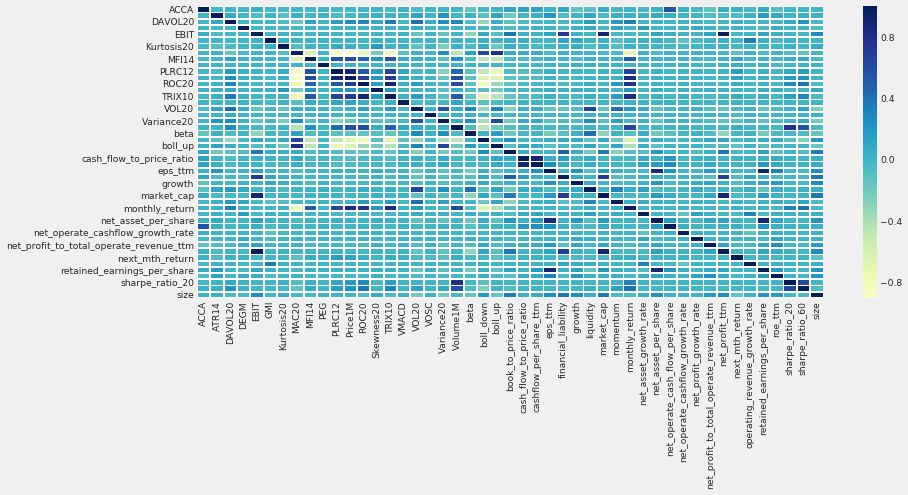

In [141]:
sns.heatmap(train.corr(), cmap="YlGnBu", center=0, linewidths=1, annot=False, fmt=".2f")
plt.show()

Removing observation with incomplete or missing data

In [142]:
train.dropna(axis=0, inplace=True)

In [143]:
train.shape

(4060, 48)

In [144]:
security_todrop = train.groupby('code').size()
maxsize = security_todrop.max()
security_todrop = security_todrop[security_todrop.values < maxsize].index.tolist()

In [145]:
train = train[~train.code.isin(security_todrop)]

Categorise the target to **return_range**.  

| Return Category | LabelEncoded | Description |
| :-: | :-: | --- |
| A | 0 | Stocks with next month return more than 10% |
| B | 1 | Stocks with next month return between 5% and 10% |
| C | 2 | Stocks with next month return between 0% and 5% |
| D | 3 | Stocks with next month return between -10% and 0% |
| E | 4 | Stocks with next month return less than -10% |


In [146]:
train['return_range'] = pd.cut(train['next_mth_return'], 
       bins=[-float("inf"),-0.1,0,0.05,0.1,float("inf")], 
       right=False, labels=['E','D','C','B','A'])

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['return_range'] = le.fit_transform(train['return_range'])

## Trying binary target with return greater than 10%
# train['return_range'] = train['return_range'] == 0

Preparing the train and test dataset

In [147]:
target = ['return_range']
to_drop = ['code', 'next_mth_return']
features = [column for column in train.columns if column not in target + to_drop]

X = train[features]
y = train[target]

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Loading the model libraries

In [149]:
from lightgbm import LGBMClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error 

Normalising the numeric features

In [150]:
scaler = StandardScaler()

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_train_std.shape

(714, 46)

In [151]:
# sns.pairplot(X_train_std, height = 2.5)
# plt.show()

### Training Data test on trial model

In [152]:
# evaluate the model
lgbm = LGBMClassifier()

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=3567)
n_scores = cross_val_score(lgbm, X_train_std, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.372 (0.017)


## Model Building
### Hyperparameter tuning for various models

- Light GBM
- Random Forest

In [153]:
from sklearn.model_selection import GridSearchCV

SEED = 3567

In [154]:
models = [
    ('lgbm', LGBMClassifier()),
    ('rf', RandomForestClassifier())
]

n_estimators = [100]
max_features = [0.6, 0.8]
max_depth = [8, 10]
learning_rate = [.01]
subsample = [0.6, 0.8]

grid_param = [
    [{ ## lgbm
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'random_state': [SEED]  
    }],
    [{ ## rf
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
#         'max_samples': subsample,
#         'criterion': ['gini', 'entropy'],
        'oob_score': [True],
        'random_state': [SEED]
    }]
]

In [155]:
cv_split = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [156]:
start_total = time.perf_counter()

for model, param in zip (models, grid_param):

    print(model[1])
    print(param)
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator=model[1], param_grid=param, 
                               cv=cv_split, scoring='accuracy', verbose=0)
    best_search.fit(X, y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('\n######')
    print('The best parameter for {} is {} with a runtime of {:.2f} minutes.'.format(model[1].__class__.__name__, 
                                                                                     best_param, run/60))
    model[1].set_params(**best_param) 

    print('######\n')

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[{'learning_rate': [0.01], 'max_depth': [8, 10], 'n_estimators': [100], 'subsample': [0.6, 0.8], 'colsample_bytree': [0.6, 0.8], 'random_state': [3567]}]

######
The best parameter for LGBMClassifier is {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'random_state': 3567, 'subsample': 0.6} with a runtime of 13.45 minutes.
######

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=No

In [157]:
from tqdm import tqdm_notebook as tqdm

model_results = []
for m in tqdm(models):
    result = {}
    print('Processing {}...'.format(type(m[1]).__name__))

    m_cv = cross_validate(m[1], X, y, cv=cv_split, return_train_score=True)
    
    result['Model'] = type(m[1]).__name__
    result['TrainScore'] = m_cv['train_score'].mean()
    result['TestScore'] = m_cv['test_score'].mean()
    result['Test3Std'] = m_cv['test_score'].std()*3
    
    model_results.append(result)

Processing LGBMClassifier...
Processing RandomForestClassifier...



In [163]:
pd.DataFrame(model_results)

,Model,Test3Std,TestScore,TrainScore
0,LGBMClassifier,0.116119,0.391398,0.727887
1,RandomForestClassifier,0.134368,0.397250,0.925709


Testing Score is only around 0.40.  The Training Score for Random Forest is too high and could be overfitting.

Selecting LGBM model for model prediction and analysis

In [164]:
best = models[0][1]
best.fit(X_train_std, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=8,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=3567, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.6, subsample_for_bin=200000, subsample_freq=0)

In [165]:
X_test_std = scaler.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
y_test['predicted_range'] = best.predict(X_test_std)

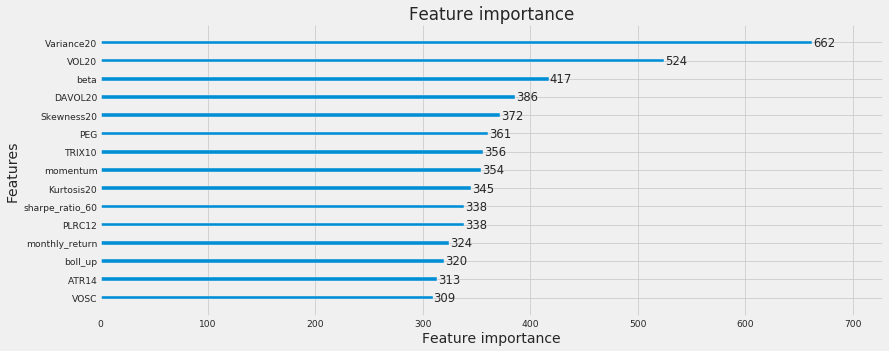

In [166]:
if type(best).__name__ == 'LGBMClassifier':
    plot_importance(best, max_num_features=15)
    plt.show()
else:
    feat_importances = pd.Series(best.feature_importances_, index=X_train_std.columns)
    feat_importances.nlargest(15).plot(kind='barh').invert_yaxis()
    plt.show()

In [167]:
# plot_tree(lgbm, figsize=(60,20))
# plt.show()

### Model Performance

Confusion Matrix

In [168]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

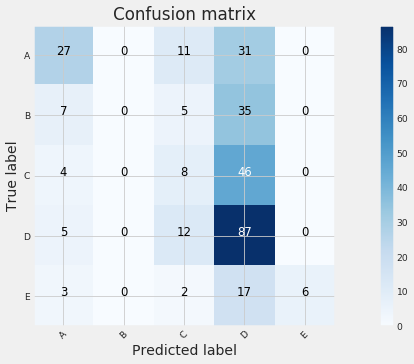

In [169]:
#importing confusion matrix

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test['return_range'], y_test['predicted_range'])

plot_confusion_matrix(confusion, ['A','B','C','D','E'], False)
plt.show()

Classification Report

In [170]:
from sklearn.metrics import classification_report

print(classification_report(y_test['return_range'], y_test['predicted_range'], 
                            target_names=['A', 'B', 'C', 'D', 'E']))

             precision    recall  f1-score   support

          A       0.59      0.39      0.47        69
          B       0.00      0.00      0.00        47
          C       0.21      0.14      0.17        58
          D       0.40      0.84      0.54       104
          E       1.00      0.21      0.35        28

avg / total       0.40      0.42      0.35       306



## Model Prediction

In [171]:
scaler_all = StandardScaler()

# Fit the scaler on the training features and transform these in one go
X_std = scaler_all.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.shape

(1020, 46)

In [172]:
# evaluate the model
model = LGBMClassifier(learning_rate = 0.01, max_depth = 15, colsample_bytree = 0.8, 
                       n_estimators = 500, random_state = 3567, subsample = 0.8)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# n_scores = cross_val_score(lgbm, X_std, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [173]:
model.fit(X_std, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=15,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=3567, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

### Stock Selection by Trained Model
- Using the model trained on past 3 years data: 2015-2017, predict the stocks that may outperform on each month betweeen 2018 to 2020 using factors observed on previous month respectively.
- The top 10 securities in category A based on predicted probability will be selected for the month for investment.
- These securities will be sold end of the month and the new batch of securites will be selected.
- Transaction cost is ignored in this analysis.
- Potentially, the model should be retrained based on the recent data available and using the updated model to perform stock selection.  However, due to complexity in retraining the models, this is not done in this analysis.

In [174]:
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

def selectStockByMonth(predictmonth):

    datamonth = datetime.strptime(predictmonth, '%Y-%m') + relativedelta(months=-1)
    datamonth = datamonth.strftime("%Y-%m")

    test = getDataByDate(datamonth).reset_index(drop=True)

    test.dropna(axis=0, inplace=True)

    security_todrop = test.groupby('code').size()
    maxsize = security_todrop.max()
    security_todrop = security_todrop[security_todrop.values < maxsize].index.tolist()

    test = test[~test.code.isin(security_todrop)]

    to_drop = ['code', 'next_mth_return']
    features = [column for column in test.columns if column not in to_drop]

    X = test[features]

    X_std = scaler_all.transform(X)
    X_std = pd.DataFrame(X_std, columns=X.columns)

    predicted_category = model.predict(X_std)
    predicted_probability = model.predict_proba(X_std)
    predicted_probability = np.max(predicted_probability, axis=1)

    results = pd.DataFrame(test.code)
    results['predictmonth'] = predictmonth
    results['predicted_range'] = predicted_category
    results['predicted_prob'] = predicted_probability
    return results[results.predicted_range == 0].sort_values('predicted_prob', 
                                                             ascending=False).head(10)

In [175]:
def getSymbolName(symbol):
    info = get_security_info(symbol)
    return info.display_name, info.name

def getMonthlyReturn(date, symbol):
    return monthly_returns.loc[pd.IndexSlice[date, :], symbol].values[0]

In [176]:
def calcPortfolioReturn(stock_returns):
    
    num_stock = len(stock_returns)
    ## Assume equally weighted portfolio
    weights = np.ones(num_stock) / num_stock
    
    return sum(weights * stock_returns)

In [177]:
from matplotlib import patheffects

def plotTimeSeries(series, title='', xlabel='', ylabel='', tickermap=''): 
    FIG_SIZE = (20,8)
    ax = series.plot(figsize=FIG_SIZE, fontsize=12, linewidth=3, linestyle='-')
    ax.set_xlabel(xlabel, fontsize = 16)
    ax.set_ylabel(ylabel, fontsize = 16)
    
    title_text_obj = ax.set_title(title, fontsize = 18, verticalalignment = 'bottom')
    title_text_obj.set_path_effects([patheffects.withSimplePatchShadow()])
    # pe = patheffects.withSimplePatchShadow(offset = (1, -1), shadow_rgbFace = (1,0,0), calpha = 0.8)

    names = series.columns
    if tickermap:
        names = names.map(tickermap)
        
    ax.legend(names, fontsize = 16)
    plt.show()

Creating the months for stock return predictions

In [178]:
predict_startdate = '2018-01-01'
predict_enddate = '2020-07-01'
predict_months = pd.date_range(predict_startdate, predict_enddate, freq='M').strftime("%Y-%m").tolist()

In [179]:
print(predict_months)

['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']


In [180]:
predicted_results = []

for month in predict_months:
    predicted_results.append(selectStockByMonth(month))   
    
predicted_results = pd.concat(predicted_results).reset_index(drop=True)

In [181]:
predicted_results['display_name'] = predicted_results['code'].apply(lambda x: getSymbolName(x)[0])
predicted_results['name'] = predicted_results['code'].apply(lambda x: getSymbolName(x)[1])
predicted_results['monthly_returns'] = predicted_results.apply(
    lambda x: getMonthlyReturn(x['predictmonth'], x['code']), axis=1)

In [182]:
predicted_results

,code,predictmonth,predicted_range,predicted_prob,display_name,name,monthly_returns
0,300014.XSHE,2018-01,0,0.774378,亿纬锂能,YWLN,-0.102639
1,601100.XSHG,2018-01,0,0.764179,恒立液压,HLYY,0.118421
2,000860.XSHE,2018-01,0,0.713528,顺鑫农业,SXNY,0.057416
3,002463.XSHE,2018-01,0,0.630907,沪电股份,HDGF,-0.171815
4,000708.XSHE,2018-01,0,0.630043,中信特钢,ZXTG,0.015152
5,002371.XSHE,2018-01,0,0.598799,北方华创,BFHC,-0.257433
6,300136.XSHE,2018-01,0,0.592767,信维通信,XWTX,-0.320602
7,600522.XSHG,2018-01,0,0.590185,中天科技,ZTKJ,-0.139398
8,600346.XSHG,2018-01,0,0.571596,恒力石化,HLSH,0.206483
9,600029.XSHG,2018-01,0,0.564871,南方航空,NFHK,-0.011986


In [183]:
portfolio_monthly_returns = predicted_results.groupby('predictmonth')['monthly_returns'].agg(calcPortfolioReturn)
portfolio_monthly_returns = pd.DataFrame(portfolio_monthly_returns)

In [184]:
portfolio_monthly_returns.index = pd.to_datetime(portfolio_monthly_returns.index)

In [185]:
portfolio_monthly_returns['cumulative_returns'] = ((1 + portfolio_monthly_returns).cumprod()-1) 

In [186]:
bmk_prices = get_price('000300.XSHG', start_date=start_date, 
               end_date=end_date, frequency='daily', 
               fields=['close'])['close']

In [187]:
bmk_name = getSymbolName('000300.XSHG')[0]
print(bmk_name)

沪深300


Benchmark Time Series

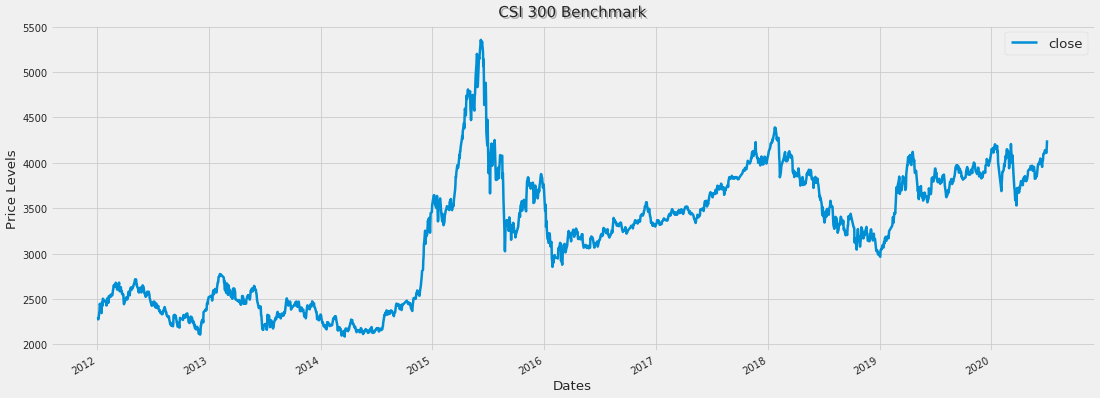

In [188]:
plotTimeSeries(pd.DataFrame(bmk_prices), 'CSI 300 Benchmark', 'Dates', 'Price Levels')

In [189]:
bmk_prices = bmk_prices.resample('M').fillna('ffill')

In [190]:
bmk_returns = bmk_prices.pct_change().dropna(axis=0, how='all')
bmk_returns = pd.DataFrame(bmk_returns)
bmk_returns.columns = ['bmk_monthly_returns']
bmk_returns.index = bmk_returns.index.map(lambda t: t.replace(day=1))

In [191]:
bmk_returns = bmk_returns['2018':'2020']
bmk_returns['bmk_cumulative_returns'] = ((1 + bmk_returns).cumprod()-1) 

In [192]:
portfolio_monthly_returns = portfolio_monthly_returns.join(bmk_returns, how='left')

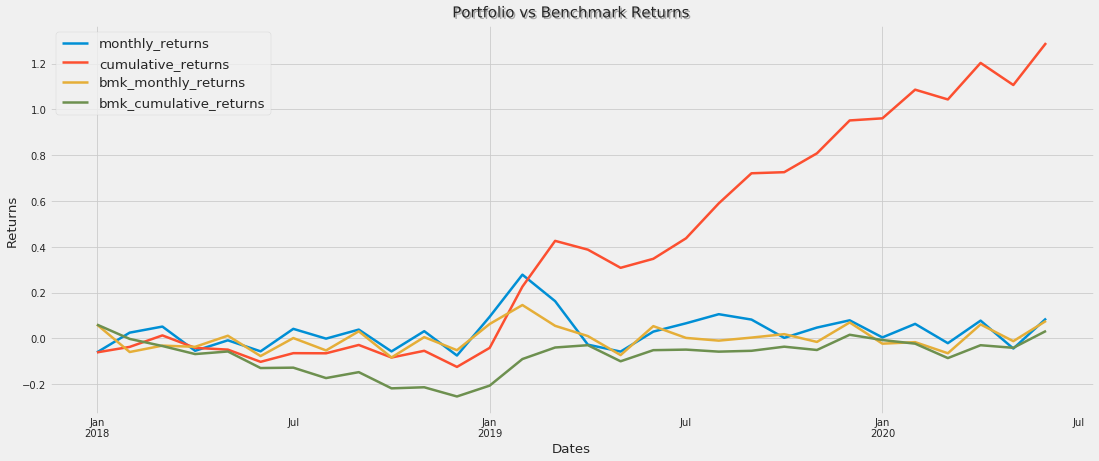

In [193]:
plotTimeSeries(portfolio_monthly_returns, 'Portfolio vs Benchmark Returns', 
               'Dates', 'Returns')

### Portfolio Performance

It is observed that the portfolio cumulative returns (red line) are consistently above the benchmark cumulative returns (green line).  On other words, the portfolio performance outperforms the benchmark consistently over the months.

In [194]:
portfolio_monthly_returns

,monthly_returns,cumulative_returns,bmk_monthly_returns,bmk_cumulative_returns
predictmonth,,,,
2018-01-01,-0.060640,-0.060640,0.060794,0.060794
2018-02-01,0.025549,-0.036640,-0.058996,-0.001789
2018-03-01,0.052040,0.013493,-0.031101,-0.032834
2018-04-01,-0.053654,-0.040885,-0.036327,-0.067968
2018-05-01,-0.007959,-0.048519,0.012111,-0.056680
2018-06-01,-0.056072,-0.101871,-0.076636,-0.128973
2018-07-01,0.042127,-0.064035,0.001903,-0.127316
2018-08-01,-0.000583,-0.064581,-0.052069,-0.172755
2018-09-01,0.038894,-0.028199,0.031297,-0.146865


## Concluding Notes

1. Model should be retrained on monthly basis with the most recent data to reflect the most market events.  I expect such retraining to contribute better portfolio performance especially during stress period.
2. Accuracy at around 40% is not fantastic.  Additional models like XGBoost, AdaBoost, SVC, Gradient Boosting, etc can be explored to see whether accuracy can improve.  On the other hand, we are only interested in stocks that falls into predicted range of 0 (predicted at least 10% monthly return), the portfolio performance still outperforms the benchmark consistently.
3. List of factors are selected based on the reference list found on the first research paper.  Other factors can be consider.  Important factors can be identified and updated on a monthly basis.  Can explore using only the top important factors to reduce noisy and overfitting.
4. This analysis focuses on data from JoinQuant and securities inside CSI300.  This can be easily extended to other securities found on different indices as long as the factor data are available.
5. Understanding the factors and respective calculation methodology provided by JoinQuant is important.  This will help in factor selection and explaining why the factors are selected for each time period.





# Thank you

Thanks to JoinQuant (聚宽) for providing such a platform and the necessary data for me to complete such an analysis.